## Problem Statement

Given Temperature and Precipitation at 9 stations and river flow at one location, predict river flow one week later.

*Predictors/Features*:  Temperature (${^o}C$) and Precipitation (mm) at 9 stations; river flow ($m^{3}s^{-1}$) at specific location (Norway).

*Predictand/Target*: River Flow ($m^{3}s^{-1}$) at the specific location (Norway) one week later

## Science Background

*Why would we expect to be able to predict river flow with precipitation, temperature, and the previous river flow? How are these variables related?*

* In the absence of new water input, the river flow will decrease slowly over time. 
* River flow has high autocorrelation over some timescale (??)
* Increased precipitation -> increased river flow
* River flow is an "integrated" response in time to precipation
* In regions with snow, temperature near/above freezing leads to melting snow and increased river flow during the melt season (i.e., spring)
* In the non-melt season, higher temperatures could leader to more evaportation and result in less river flow, but this is likely a small impact 

*Other aspects of the data to consider:*

* All datasets could have a climate change related trend and/or changes in variability 
* All data will have a seasonal cycle

## Modeling Approach

I like to look carefully at the data, start with simple models, and then move to more complex models

*How do I look at the data?*
* Plot the timeseries and subsets of the timeseries
* Mean
* Variance
* Trend
* Climatology
* Simultaneous Correlations between all features and target

*What types of models do I use?*
* Linear Regression (with and without regularization) 
* Fully Connected Neural Network with only a few layers

*How do I test the models to determine if they are trustworthy?*
* Compare train and test
* Compare with climatology and persistence 

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
from sklearn import preprocessing

import tensorflow as tf
from tensorflow.keras import backend as k
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras import optimizers
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


### My Functions -- move to utils

In [2]:
def lasso(X,Y):

    # X_train[time,features]
    # Y_train[time,targets]

    regr = LassoCV(cv=5,max_iter=5000).fit(X,Y)
    Y_pred = regr.predict(X)
    
    r_squared,Y_pred=get_r2(X,Y,regr)
    
    return regr,regr.coef_,r_squared,Y_pred

In [3]:
def ridge(X,Y):

    # X_train[time,features]
    # Y_train[time,targets]

    regr = RidgeCV(cv=5).fit(X,Y)
    Y_pred = regr.predict(X)
    
    r_squared,Y_pred=get_r2(X,Y,regr)
    
    return regr,regr.coef_,r_squared,Y_pred

In [4]:
def lr(X,Y):

    # X_train[time,features]
    # Y_train[time,targets]

    regr = LinearRegression().fit(X,Y)
    Y_pred = regr.predict(X)
    
    r_squared,Y_pred=get_r2(X,Y,regr)
    
    return regr,regr.coef_,r_squared,Y_pred

In [5]:
def tomsensomodel_regression(X,Y):
    
    model = Sequential()

    model.add(Dense(8, input_dim=X.shape[1],activation='tanh',
                kernel_initializer='he_normal',
                kernel_regularizer=regularizers.l1(0.02),
                bias_initializer='he_normal'))

    model.add(Dense(8, activation='tanh',
                kernel_initializer='he_normal',
                bias_initializer='he_normal'))

    model.add(Dense(1,name='output'))

    model.compile(optimizer=optimizers.Adam(lr=0.001), 
                  loss ='mean_squared_error', 
                  metrics = ['mse'])
        
    model.fit(X,Y,epochs=250, batch_size=100,verbose=0)
    
    return(model)

In [6]:
def daily_climo(ds,varname):
  
    # Average daily data
    da_day_clim = ds[varname].groupby('time.dayofyear').mean('time')
    da_day_clim = da_day_clim.chunk({'dayofyear': 366})
    
    # Pad the daily climatolgy with nans
    
    if (varname=='flow'):
        x = np.empty((366))
        x.fill(np.nan)
    
        _da = xr.DataArray(x, coords=[da_day_clim.dayofyear],
                           dims = da_day_clim.dims)    
    else:
        x = np.empty((366,len(da_day_clim.stations)))
        x.fill(np.nan)
    
        _da = xr.DataArray(x, coords=[da_day_clim.dayofyear,
                                      da_day_clim.stations],
                           dims = da_day_clim.dims)
    
    da_day_clim_wnan = da_day_clim.combine_first(_da)

    # Period rolling twice to make it triangular smoothing
    # See https://bit.ly/2H3o0Mf
    da_day_clim_smooth = da_day_clim_wnan.copy()

    for i in range(2):
        # Extand the DataArray to allow rolling to do periodic
        da_day_clim_smooth = xr.concat([da_day_clim_smooth[-15:],
                                        da_day_clim_smooth,
                                        da_day_clim_smooth[:15]],
                                        'dayofyear')
        # Rolling mean
        da_day_clim_smooth = da_day_clim_smooth.rolling(dayofyear=31,
                                                        center=True,
                                                        min_periods=1).mean()
        # Drop the periodic boundaries
        da_day_clim_smooth = da_day_clim_smooth.isel(dayofyear=slice(15, -15))

    # Extract the original days
    da_day_clim_smooth = da_day_clim_smooth.sel(dayofyear=da_day_clim.dayofyear)
    da_day_clim_smooth.name=varname
    
    # Save file
    #da_day_clim_smooth.to_netcdf(outclimFile)

    return da_day_clim_smooth

In [7]:
def get_r2(X,Y,model):
    
    pred = model.predict(X).squeeze()
    rsq=np.corrcoef(Y,pred)[0,1]
    return rsq,pred


## Read Data

In [8]:
data_path='../data/'
file='climateai_coding_challenge_data_v2.nc'
ds=xr.open_dataset(data_path+file)
ds

<xarray.Dataset>
Dimensions:         (station_number: 9, time_flow: 21542, time_weather: 21546)
Coordinates:
  * time_flow       (time_flow) datetime64[ns] 1958-01-04 ... 2016-12-26
  * time_weather    (time_weather) datetime64[ns] 1957-01-01 ... 2015-12-31
  * station_number  (station_number) int64 0 1 2 3 4 5 6 7 8
    lat             float64 ...
    lon             float64 ...
Data variables:
    flow            (time_flow) float64 ...
    temperature     (time_weather, station_number) float64 ...
    precipitation   (time_weather, station_number) float64 ...

In [9]:
print(ds.sel(time_weather='1988-02-29'))

<xarray.Dataset>
Dimensions:         (station_number: 9, time_flow: 21542)
Coordinates:
  * time_flow       (time_flow) datetime64[ns] 1958-01-04 ... 2016-12-26
    time_weather    datetime64[ns] 1988-02-29
  * station_number  (station_number) int64 0 1 2 3 4 5 6 7 8
    lat             float64 60.23
    lon             float64 9.37
Data variables:
    flow            (time_flow) float64 1.724 0.9609 0.001 ... 3.557 3.402 1.813
    temperature     (station_number) float64 ...
    precipitation   (station_number) float64 ...


### Extract Dates to Match for features and target

In [10]:
ds_trunc_precip=ds['precipitation'].sel(time_weather=slice('1957-12-28','2015-12-24'))
ds_trunc_temp=ds['temperature'].sel(time_weather=slice('1957-12-28','2015-12-24'))
ds_trunc_flow=ds['flow'].sel(time_flow=slice('1958-01-04','2015-12-31'))

print(ds_trunc_precip)
print(ds_trunc_temp)
print(ds_trunc_flow)

<xarray.DataArray 'precipitation' (time_weather: 21178, station_number: 9)>
[190602 values with dtype=float64]
Coordinates:
  * time_weather    (time_weather) datetime64[ns] 1957-12-28 ... 2015-12-24
  * station_number  (station_number) int64 0 1 2 3 4 5 6 7 8
    lat             float64 60.23
    lon             float64 9.37
<xarray.DataArray 'temperature' (time_weather: 21178, station_number: 9)>
[190602 values with dtype=float64]
Coordinates:
  * time_weather    (time_weather) datetime64[ns] 1957-12-28 ... 2015-12-24
  * station_number  (station_number) int64 0 1 2 3 4 5 6 7 8
    lat             float64 60.23
    lon             float64 9.37
<xarray.DataArray 'flow' (time_flow: 21181)>
array([1.723781e+00, 9.608816e-01, 1.000000e-03, ..., 4.998840e+00,
       4.428777e+00, 4.047925e+00])
Coordinates:
  * time_flow  (time_flow) datetime64[ns] 1958-01-04 1958-01-05 ... 2015-12-31
    lat        float64 60.23
    lon        float64 9.37


### Look at data 

Text(0.5, 1.0, 'River Flow')

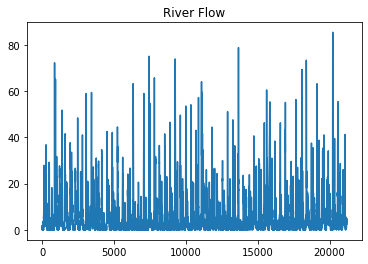

In [11]:
plt.plot(ds_trunc_flow)
plt.title('River Flow')

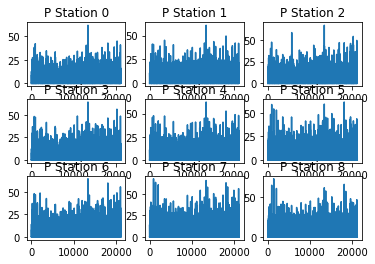

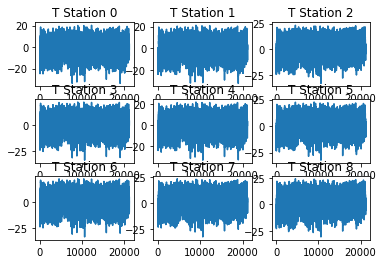

In [12]:
ncols=3
nrows=3

fig = plt.figure()
for i,station in enumerate(ds['station_number']):
    plt.subplot(nrows,ncols,i+1)
    plt.plot(ds_trunc_precip.sel(station_number=station))
    plt.title('P Station '+str(i))
    
fig = plt.figure()
for i,station in enumerate(ds['station_number']):
    plt.subplot(nrows,ncols,i+1)
    plt.plot(ds_trunc_temp.sel(station_number=station))
    plt.title('T Station '+str(i))

## Define Features and Targets and put into `numpy` array 
Features (`X`): precipitation, temperature, flow 
Target (`Y`): flow one week later

In [13]:
X=np.concatenate((ds_trunc_precip,ds_trunc_temp),axis=1)
Y=ds_trunc_flow.where(ds_trunc_flow['time_flow'].isin(ds_trunc_precip['time_weather']+pd.Timedelta(days=7)), drop=True).values

In [14]:
print('Check Features and Target Dimensions')
print('Features (X): ',X.shape)
print('Target (Y): ',Y.shape)

nsamples=X.shape[0]
nfeatures=X.shape[1]

print("Samples: ",nsamples)
print("features: ", nfeatures)

Check Features and Target Dimensions
Features (X):  (21178, 18)
Target (Y):  (21178,)
Samples:  21178
features:  18


### Split Data into Training and Test

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.8,shuffle=False)

ntrain=X_train.shape[0]
ntest=X_test.shape[0]

print('Training Size: ',ntrain)
print('Testing Size: ',ntest)

Training Size:  16942
Testing Size:  4236


### Quick look at subset of training data

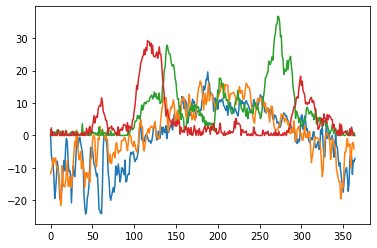

In [16]:
plt.plot(X_train[0:365,10])
plt.plot(X_train[366:730,10])
plt.plot(Y_train[0:365])
plt.plot(Y_train[366:730])

### Take a look at training data & Relationships between variables

#### Mean, Variance, Trend

 
-3.741e-06 x + 1.958
Check Stats:  Station:  0 Mean:  1.9262483759860498 Var:  15.455094857637402
 
-5.6e-06 x + 1.988
Check Stats:  Station:  1 Mean:  1.9409691892184335 Var:  18.085235105146513
 
1.854e-06 x + 1.996
Check Stats:  Station:  2 Mean:  2.012182742523927 Var:  19.19313109382876
 
-2.989e-08 x + 2.135
Check Stats:  Station:  3 Mean:  2.1352142586775513 Var:  19.693323703477507
 
2.81e-06 x + 2.177
Check Stats:  Station:  4 Mean:  2.200838152245751 Var:  21.68856732248969
 
-4.57e-06 x + 2.2
Check Stats:  Station:  5 Mean:  2.161686930984431 Var:  23.344217977509388
 
-1.011e-06 x + 2.255
Check Stats:  Station:  6 Mean:  2.2462519170830086 Var:  21.814551810470256
 
-2.393e-06 x + 2.352
Check Stats:  Station:  7 Mean:  2.33192066934297 Var:  28.107689566602524
 
-2.906e-06 x + 2.233
Check Stats:  Station:  8 Mean:  2.2084818804389665 Var:  25.71659848188023
 
4.796e-05 x - 0.6545
Check Stats:  Station:  9 Mean:  -0.24825876416061735 Var:  69.03303289251235
 
5.435e-05 x +

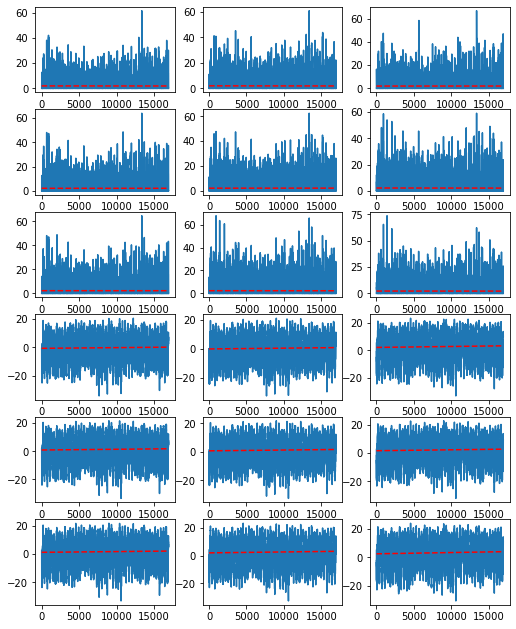

In [17]:
plt.figure(figsize=(8.5,11))
y=np.arange(ntrain)

for i in range(nfeatures):

    plt.subplot(6,3,i+1)

    z = np.polyfit(y,X_train[:,i],1)
    p = np.poly1d(z)
    print(p)
    plt.plot(y,X_train[:,i])
    plt.plot(p(y),"r--")
    
    print("Check Stats: ", "Station: ",i, "Mean: ", X_train[:,i].mean(axis=0),"Var: ", X_train[:,i].var(axis=0))
    

### Summary
* No clear trend
* Data will need to be standardized

#### How correlated are all the features and target with each other?

/homes/kpegion/.conda/envs/climateai/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


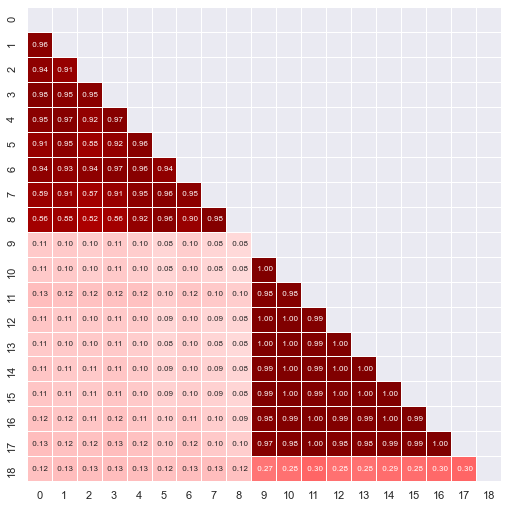

In [18]:
tmp_data=np.hstack((X_train,np.expand_dims(Y_train, axis=1)))
d = pd.DataFrame(data=tmp_data)
corr=d.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(8.5,11))
sns.set(font_scale=1)
ax=sns.heatmap(corr,square=True,linewidths=0.5,fmt=" .2f", \
               annot=True,mask=mask,cmap='seismic', \
               vmin=-1,vmax=1,cbar=False,annot_kws={"size": 8})

### Summary
* Temperature stations highly correlated with each other
* Precipitation stations highly correlated with each other
* High correlation between features means that there is not a lot of independent information in each of the features; will need regularization to avoid overfitting
* Precipitation is weakly correlated with flow one week later

### Seasonal Cycle & Anomalies

# Create an `xarray.Dataset` of training and test data

In [19]:
ds_tmp1=xr.DataArray(X_train[:,0:9],
                    coords={'time':ds_trunc_precip['time_weather'][0:ntrain].values,
                            'stations': ds_trunc_precip['station_number'][0:9].values},
                    dims=['time','stations']).to_dataset(name='precipitation')
ds_tmp2=xr.DataArray(X_train[:,9::],
                    coords={'time':ds_trunc_precip['time_weather'][0:ntrain].values,
                            'stations': ds_trunc_precip['station_number'][0:9].values},
                    dims=['time','stations']).to_dataset(name='temperature')
ds_Xtrain=xr.merge([ds_tmp1,ds_tmp2])


ds_Ytrain=xr.DataArray(Y_train[:],
                    coords={'time':ds_trunc_flow['time_flow'][0:ntrain].values},
                    dims=['time']).to_dataset(name='flow')

### Calculate climatology and anomalies

In [20]:
precip_climo=daily_climo(ds_Xtrain,'precipitation')
temp_climo=daily_climo(ds_Xtrain,'temperature')
climo_Xtrain=xr.merge([precip_climo,temp_climo])

climo_Ytrain=daily_climo(ds_Ytrain,'flow').to_dataset(name='flow')

ds_anoms_Xtrain=ds_Xtrain.groupby('time.dayofyear')-climo_Xtrain
ds_anoms_Ytrain=ds_Ytrain.groupby('time.dayofyear')-climo_Ytrain

/homes/kpegion/.conda/envs/climateai/lib/python3.7/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 47 times more chunks
  return self.array[key]
/homes/kpegion/.conda/envs/climateai/lib/python3.7/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 47 times more chunks
  return self.array[key]
/homes/kpegion/.conda/envs/climateai/lib/python3.7/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 47 times more chunks
  return self.array[key]


### Plot the Climatology for the temperature and precip stations

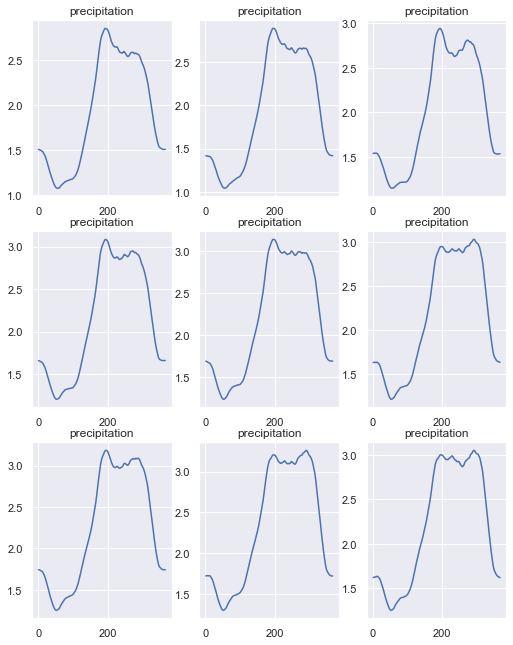

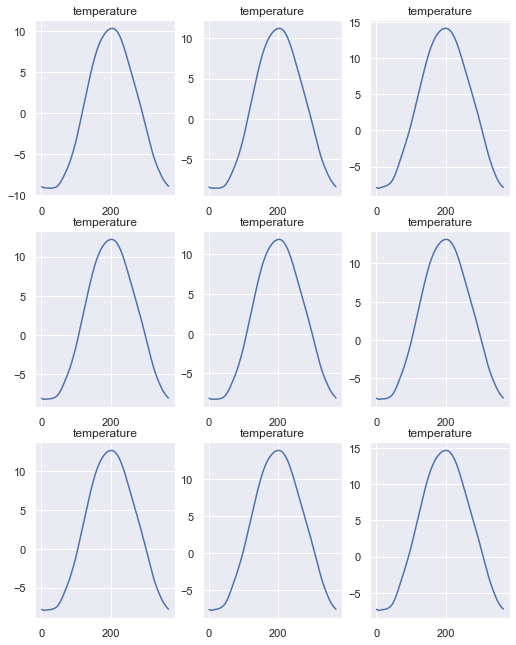

In [21]:
for v in ['precipitation','temperature']:
    plt.figure(figsize=(8.5,11))
    for i in range(9):

        plt.subplot(3,3,i+1)
        plt.plot(climo_Xtrain['dayofyear'],climo_Xtrain[v][:,i])
        plt.title(v)

Text(0.5, 1.0, 'flow')

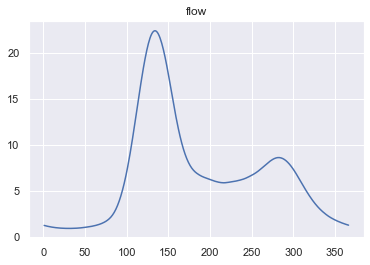

In [22]:
plt.plot(climo_Ytrain['dayofyear'],climo_Ytrain['flow'])
plt.title('flow')

### Standardize the Data

In [23]:
ds_anoms_Xtrain_scaled=(ds_anoms_Xtrain-ds_anoms_Xtrain.mean(dim='time'))/ds_anoms_Xtrain.std(dim='time')
ds_anoms_Ytrain_scaled=(ds_anoms_Ytrain-ds_anoms_Ytrain.mean(dim='time'))/ds_anoms_Ytrain.std(dim='time')

Xtrain_scaled=np.concatenate((ds_anoms_Xtrain_scaled['precipitation'].values,ds_anoms_Xtrain_scaled['temperature'].values),axis=1)
Ytrain_scaled=ds_anoms_Ytrain_scaled['flow'].values

### Linear Regression Model: Standard (no regularization)

In [24]:
regr,coeffs,rsq_train,Ypred=lr(Xtrain_scaled,Ytrain_scaled)
print('R^2 Train Standard : ', rsq_train)
print(coeffs)

(16942,) (16942,)
(2, 2)
R^2 Train Standard :  0.1824987874125439
[-0.09996693  0.07180456  0.05980828  0.19365863 -0.05513582 -0.05417346
 -0.05257812  0.12928097 -0.02558817  0.52934008 -0.19677572  0.05537018
  0.96020937 -0.84667081  0.46022047 -0.93196492 -0.01940192  0.02962587]


### Linear Regression Model w/LASSO (R1)

In [25]:
regr,coeffs,rsq_train,Ypred=lasso(Xtrain_scaled,Ytrain_scaled)
print('R^2 Train LASSO : ', rsq_train)
print(coeffs)

(16942,) (16942,)
(2, 2)
R^2 Train LASSO :  0.18172992439371094
[-0.08429757  0.05679814  0.05887784  0.1667225  -0.02854811 -0.05319224
 -0.03621393  0.10466787 -0.01714674  0.39838865 -0.          0.09451387
  0.45260372 -0.59788159  0.30271239 -0.61006127 -0.00154841 -0.        ]


/homes/kpegion/.conda/envs/climateai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.796115610684865, tolerance: 1.6941999999999997
  positive)


### Linear Regression Model w/Ridge (R2)

In [26]:
regr,coeffs,rsq_train,Ypred=ridge(Xtrain_scaled,Ytrain_scaled)
print('R^2 Train Ridge : ', rsq_train)
print(coeffs)

(16942,) (16942,)
(2, 2)
R^2 Train Ridge :  0.18144748744480022
[-0.09394811  0.06661012  0.06084593  0.18425627 -0.04598751 -0.05490543
 -0.04846192  0.12330792 -0.02367418  0.40840813 -0.05537421  0.15944633
  0.2714874  -0.43991192  0.31426045 -0.52963352 -0.08195034 -0.00789912]


### Summary:
Linear regression can explain 18% of the variance of anomalous river flow using precipitation and temperature 1-week prior to the prediction.

### Simple ANN based on Toms et al.

In [27]:
nntoms=tomsensomodel_regression(Xtrain_scaled,Ytrain_scaled)
rsq_train,Y_pred_train=get_r2(Xtrain_scaled,Ytrain_scaled,nntoms)
print('R^2 Train NN: ',rsq_train)


(16942,) (16942,)
(2, 2)
R^2 Train NN:  0.17071139401236743


### Summary: 

The NN does not improve the prediction over linear regression. 

*How can I improve the prediction?* 
* River flow has a relatively high autocorrelation so should be a good predictor; include it
* The temperature and precipitation over a period of time (e.g., weeks) could be better predictors than using just one-day of precipitation; incorporate time-lagged information into the predictors

## Summary of Results


## Next Steps
1. Incorporate time-lagged temperature and precipitation information
2. Include the latest available value of the river flow in the prediction
3. Compare with test data
3. Generalize time handling
4. Modularize